# Shot Data Preprocessing and Forecast

### 1. Read the data
Read the data from .csv file.
The example data file is Kobe_Bryant_Shot.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data filename
filename_kobe = 'Kobe_Bryant_Shot.csv'
filename_curry = 'Stephen_Curry_Shot.csv'

# Read the data
data_kobe = pd.read_csv(filename_kobe)
data_curry = pd.read_csv(filename_curry)
data_curry = data_curry.rename(str.lower, axis = 'columns')

In [2]:
# The shape of data
print('Kobe:',data_kobe.shape)
print('Curry:',data_curry.shape)

Kobe: (30697, 25)
Curry: (9420, 25)


In [3]:
# Some example of data
data_curry.head()

,grid_type,game_id,game_event_id,player_id,player_name,team_id,team_name,period,minutes_remaining,seconds_remaining,...,shot_zone_range,shot_distance,loc_x,loc_y,shot_attempted_flag,shot_made_flag,game_date,htm,vtm,season
0,Shot Chart Detail,21200010,33,201939,Stephen Curry,1610612744,Golden State Warriors,1,8,31,...,24+ ft.,25,-45,246,1,0,20121031,PHX,GSW,2012
1,Shot Chart Detail,21200010,64,201939,Stephen Curry,1610612744,Golden State Warriors,1,5,58,...,16-24 ft.,21,-188,102,1,0,20121031,PHX,GSW,2012
2,Shot Chart Detail,21200010,73,201939,Stephen Curry,1610612744,Golden State Warriors,1,5,13,...,24+ ft.,25,-237,99,1,0,20121031,PHX,GSW,2012
3,Shot Chart Detail,21200010,199,201939,Stephen Curry,1610612744,Golden State Warriors,2,6,18,...,16-24 ft.,21,157,148,1,0,20121031,PHX,GSW,2012
4,Shot Chart Detail,21200010,238,201939,Stephen Curry,1610612744,Golden State Warriors,2,2,43,...,24+ ft.,22,-226,-17,1,0,20121031,PHX,GSW,2012


### 2. Data Cleaning
Clean the data with vacancy in "shot_made_flag" and some irrelevant features.
For example, we do not need features such as game_event_id, game_id, playoffs, team_id, team_name, game_date, matchup, opponent and shot_id to forecast hit rate.

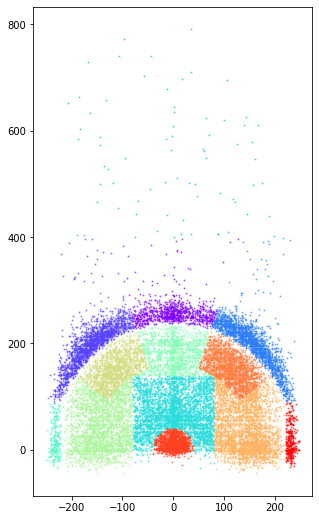

(25697, 14)


,combined_shot_type,loc_x,loc_y,period,season,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,shot_zone,remain_time,dist,angle
1,Jump Shot,-157,0,1,2000,0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,Mid-Range L,622,157.000000,-90.000000
2,Jump Shot,-101,135,1,2000,1,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,Mid-Range LC,465,168.600119,-36.801931
3,Jump Shot,138,175,1,2000,0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,Mid-Range RC,412,222.865430,38.258303
4,Dunk,0,0,2,2000,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,Restricted Area,379,0.000000,0.000000
5,Jump Shot,-145,-11,3,2000,0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,Mid-Range L,572,145.416643,-94.338267


In [4]:
# Clean the vacancy in "shot_made_flag"
data_kobe = data_kobe[pd.notnull(data_kobe['shot_made_flag'])]

import matplotlib.cm as cm
def scatterbygroup(data, feature):
    gb = data.groupby(feature)
    cl = cm.rainbow(np.linspace(0,1,len(gb)))
    for g,c in zip(gb,cl):
        plt.scatter(g[1].loc_x,g[1].loc_y,color = c,s = 1, alpha = 0.5)

data_kobe = data_kobe.drop(['game_event_id', 'game_id', 'playoffs', 'team_id',\
                  'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'], axis=1)
data_kobe = data_kobe.drop(['action_type'], axis=1)
data_kobe=data_kobe.drop(['lon', 'lat'], axis=1)

data_kobe['shot_zone']=data_kobe['shot_zone_basic']
area={'Left Side(L)':'L', 'Left Side Center(LC)': 'LC', 'Right Side Center(RC)':'RC',
     'Center(C)':'C', 'Right Side(R)':'R', 'Back Court(BC)':'BC'}
data_kobe.loc[data_kobe.shot_zone_basic=='Mid-Range', 'shot_zone']='Mid-Range '+data_kobe.shot_zone_area.apply(lambda x:area[x])
data_kobe.loc[data_kobe.shot_zone_basic=='Above the Break 3', 'shot_zone']='3PT '+data_kobe.shot_zone_area.apply(lambda x:area[x])
data_kobe.loc[(data_kobe.shot_zone_basic=='Above the Break 3')&(data_kobe.shot_zone_area=='Back Court(BC)'), 'shot_zone']='Backcourt'
plt.figure(figsize=(5,9))
scatterbygroup(data_kobe, 'shot_zone')
plt.show()

data_kobe['remain_time'] = data_kobe['minutes_remaining'] * 60 + data_kobe['seconds_remaining']
data_kobe = data_kobe.drop(['minutes_remaining', 'seconds_remaining'], axis = 1)

data_kobe['season'] = data_kobe['season'].apply(lambda x: int(x.split('-')[0]))

data_kobe['shot_made_flag'] = data_kobe['shot_made_flag'].astype(int)

data_kobe=data_kobe.drop(['shot_distance'],axis=1)
data_kobe['dist']=(data_kobe.loc_x**2+data_kobe.loc_y**2)**0.5
data_kobe['angle']=np.arctan2(data_kobe.loc_x,data_kobe.loc_y)/np.pi*180.0
print(data_kobe.shape)
data_kobe.head()

In [5]:
data_kobe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 14 columns):
combined_shot_type    25697 non-null object
loc_x                 25697 non-null int64
loc_y                 25697 non-null int64
period                25697 non-null int64
season                25697 non-null int64
shot_made_flag        25697 non-null int32
shot_type             25697 non-null object
shot_zone_area        25697 non-null object
shot_zone_basic       25697 non-null object
shot_zone_range       25697 non-null object
shot_zone             25697 non-null object
remain_time           25697 non-null int64
dist                  25697 non-null float64
angle                 25697 non-null float64
dtypes: float64(2), int32(1), int64(5), object(6)
memory usage: 4.1+ MB


Preprocessing for Curry's shot data

In [6]:
data_curry = data_curry.drop(['grid_type', 'game_id', 'game_event_id', 'player_id', 'player_name', 'team_id', 
                             'team_name', 'event_type', 'shot_attempted_flag', 'game_date', 'htm', 'vtm'], axis=1)

In [7]:
action={'Jump Shot': 'Jump Shot', 'Driving Dunk Shot': 'Dunk', 'Layup Shot':'Layup',
       'Running Jump Shot':'Jump Shot', 'Reverse Dunk Shot':'Dunk', 'Slam Dunk Shot':'Dunk',
       'Driving Layup Shot':'Layup', 'Turnaround Jump Shot':'Jump Shot', 'Reverse Layup Shot':'Layup',
       'Tip Shot':'Tip Shot', 'Running Hook Shot':'Hook Shot', 'Alley Oop Dunk Shot':'Dunk',
       'Dunk Shot':'Dunk', 'Alley Oop Layup shot':'Layup', 'Running Dunk Shot':'Dunk',
       'Driving Finger Roll Shot':'Layup', 'Running Layup Shot':'Layup',
       'Finger Roll Shot':'Layup', 'Fadeaway Jump Shot':'Jump Shot', 'Follow Up Dunk Shot':'Dunk',
       'Hook Shot':'Hook Shot', 'Turnaround Hook Shot':'Hook Shot', 'Jump Hook Shot':'Jump Shot',
       'Running Finger Roll Shot':'Layup', 'Jump Bank Shot':'Jump Shot',
       'Turnaround Finger Roll Shot':'Layup', 'Hook Bank Shot':'Bank Shot',
       'Driving Hook Shot':'Hook Shot', 'Running Tip Shot':'Tip Shot',
       'Running Reverse Layup Shot':'Layup', 'Driving Finger Roll Layup Shot':'Layup',
       'Fadeaway Bank shot':'Bank Shot', 'Pullup Jump shot':'Jump Shot', 'Finger Roll Layup Shot':'Layup',
       'Turnaround Fadeaway shot':'Jump Shot', 'Driving Reverse Layup Shot':'Layup',
       'Driving Slam Dunk Shot':'Dunk', 'Step Back Jump shot':'Jump Shot',
       'Turnaround Bank shot':'Bank Shot', 'Reverse Slam Dunk Shot':'Dunk',
       'Floating Jump shot':'Jump Shot', 'Putback Slam Dunk Shot':'Dunk',
       'Running Bank shot':'Bank Shot', 'Driving Bank shot':'Bank Shot', 'Driving Jump shot':'Jump Shot',
       'Putback Layup Shot':'Layup', 'Putback Dunk Shot':'Dunk',
       'Running Finger Roll Layup Shot':'Layup', 'Pullup Bank shot':'Bank Shot',
       'Running Slam Dunk Shot':'Dunk', 'Cutting Layup Shot':'Layup',
       'Driving Floating Jump Shot':'Jump Shot', 'Running Pull-Up Jump Shot':'Jump Shot',
       'Tip Layup Shot':'Layup', 'Driving Floating Bank Jump Shot':'Jump Shot',
       'Cutting Finger Roll Layup Shot':'Layup', 'Turnaround Fadeaway Bank Jump Shot':'Jump Shot',
       'Step Back Bank Jump Shot':'Jump Shot', 'Cutting Dunk Shot':'Dunk'}
data_curry['combined_shot_type']=data_curry.action_type.apply(lambda x:action[x])
data_curry=data_curry.drop(['action_type'], axis=1)

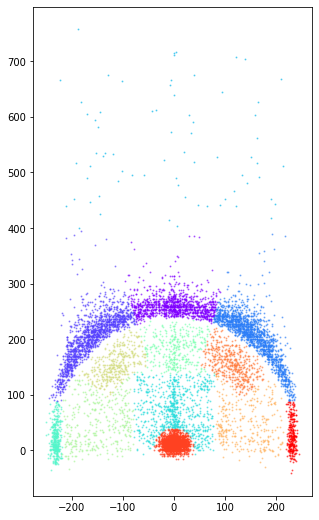

In [8]:
data_curry['shot_zone']=data_curry['shot_zone_basic']
area={'Left Side(L)':'L', 'Left Side Center(LC)': 'LC', 'Right Side Center(RC)':'RC',
     'Center(C)':'C', 'Right Side(R)':'R', 'Back Court(BC)':'BC'}
data_curry.loc[data_curry.shot_zone_basic=='Mid-Range', 'shot_zone']='Mid-Range '+data_curry.shot_zone_area.apply(lambda x:area[x])
data_curry.loc[data_curry.shot_zone_basic=='Above the Break 3', 'shot_zone']='3PT '+data_curry.shot_zone_area.apply(lambda x:area[x])
data_curry.loc[(data_curry.shot_zone_basic=='Above the Break 3')&(data_curry.shot_zone_area=='Back Court(BC)'), 'shot_zone']='Backcourt'
plt.figure(figsize=(5,9))
scatterbygroup(data_curry, 'shot_zone')
plt.show()

In [9]:
data_curry['remain_time'] = data_curry['minutes_remaining'] * 60 + data_curry['seconds_remaining']
data_curry = data_curry.drop(['minutes_remaining', 'seconds_remaining'], axis = 1)

data_curry['shot_made_flag'] = data_curry['shot_made_flag'].apply(lambda x: int(x))

data_curry=data_curry.drop(['shot_distance'],axis=1)
data_curry['dist']=(data_curry.loc_x**2+data_curry.loc_y**2)**0.5
data_curry['angle']=np.arctan2(data_curry.loc_x,data_curry.loc_y)/np.pi*180.0

print(data_curry.shape)
data_curry.head()

(9420, 14)


,period,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,loc_x,loc_y,shot_made_flag,season,combined_shot_type,shot_zone,remain_time,dist,angle
0,1,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,-45,246,0,2012,Jump Shot,3PT C,511,250.081987,-10.366323
1,1,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,-188,102,0,2012,Jump Shot,Mid-Range L,358,213.887821,-61.517814
2,1,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,-237,99,0,2012,Jump Shot,3PT LC,313,256.846258,-67.328656
3,2,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,157,148,0,2012,Jump Shot,Mid-Range RC,378,215.761442,46.690205
4,2,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,-226,-17,0,2012,Jump Shot,Left Corner 3,163,226.638479,-94.301758


In [10]:
data_curry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9420 entries, 0 to 9419
Data columns (total 14 columns):
period                9420 non-null int64
shot_type             9420 non-null object
shot_zone_basic       9420 non-null object
shot_zone_area        9420 non-null object
shot_zone_range       9420 non-null object
loc_x                 9420 non-null int64
loc_y                 9420 non-null int64
shot_made_flag        9420 non-null int64
season                9420 non-null int64
combined_shot_type    9420 non-null object
shot_zone             9420 non-null object
remain_time           9420 non-null int64
dist                  9420 non-null float64
angle                 9420 non-null float64
dtypes: float64(2), int64(6), object(6)
memory usage: 1.0+ MB


### 3. Visualization of Curry's Data

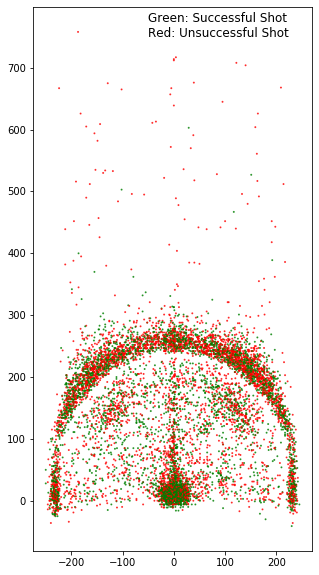

In [11]:
colors={0:'red', 1:'green'}
plt.figure(figsize=(5,10))
plt.scatter(data_curry.loc_x, data_curry.loc_y, c=data_curry['shot_made_flag'].apply(lambda x:colors[x]), s=1, alpha=0.7)
plt.annotate('Green: Successful Shot\nRed: Unsuccessful Shot', xy=[-50,750], size=12)
plt.show()

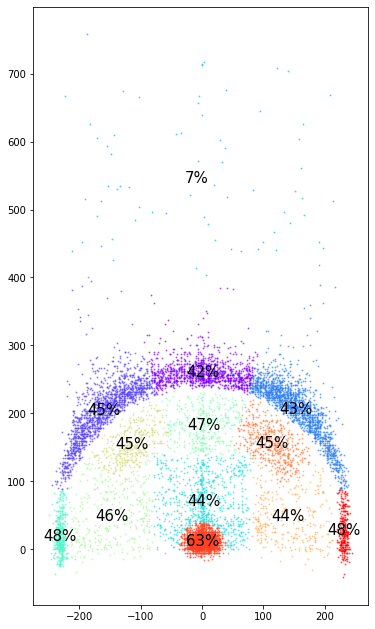

In [12]:
def gethitrate(data, figure):
    count1=dict(data[figure].value_counts())
    xdata=list(count1.keys())
    ydata1=list(count1.values())
    count2=dict(data[data.shot_made_flag==1][figure].value_counts())
    for x in xdata:
        if x not in count2.keys():
            count2[x]=0
    ydata2=[count2[x] for x in xdata]
    hitrate=np.array([y2/y1 for y1,y2 in zip(ydata1,ydata2)])
    return (xdata,ydata1,ydata2,hitrate)
figure='shot_zone'
plt.figure(figsize=(6,11))
scatterbygroup(data_curry, 'shot_zone')
(xdata,ydata1,ydata2,hitrate)=gethitrate(data_curry, 'shot_zone')
for i in range(len(xdata)):
    plt.annotate('%.0f%%'%(hitrate[i]*100), xy=(data_curry[data_curry[figure]==xdata[i]].loc_x.mean(),
                                                data_curry[data_curry[figure]==xdata[i]].loc_y.mean()),
                 size=15, horizontalalignment='center', verticalalignment='center')

In [13]:
def gethitrate2(data1,data2, figure):
    count1_1=dict(data1[figure].value_counts())
    xdata1=list(count1_1.keys())
    ydata1_1=list(count1_1.values())
    count1_2=dict(data1[data1.shot_made_flag==1][figure].value_counts())
    for x in xdata1:
        if x not in count1_2.keys():
            count1_2[x]=0
    ydata1_2=[count1_2[x] for x in xdata1]
    hitrate1=[y2/y1 for y1,y2 in zip(ydata1_1,ydata1_2)]
    
    count2_1=dict(data2[figure].value_counts())
    for x in xdata1:
        if x not in count2_1.keys():
            count2_1[x]=0
    ydata2_1=[count2_1[x] for x in xdata1]
    
    count2_2=dict(data2[data2.shot_made_flag==1][figure].value_counts())
    for x in xdata1:
        if x not in count2_2.keys():
            count2_2[x]=0
    ydata2_2=[count2_2[x] for x in xdata1]
    hitrate2=[y2/y1 for y1,y2 in zip(ydata2_1,ydata2_2)]
    return (xdata1, ydata1_1,ydata1_2, hitrate1, ydata2_1, ydata2_2, hitrate2)


gethitrate2(data_kobe, data_curry, 'shot_type')

(['2PT Field Goal', '3PT Field Goal'],
 [20285, 5412],
 [9683, 1782],
 [0.4773477939364062, 0.32926829268292684],
 [4539, 4881],
 [2378, 2118],
 [0.5239039435999119, 0.4339274738783036])

In [14]:
def plotbyfigure2(data1, data2, figure, title, size=(10,6), wid=0.3):
    (xdata1,ydata1_1,ydata1_2,hitrate1,ydata2_1,ydata2_2, hitrate2)=gethitrate2(data1, data2, figure)
    
    xnum=np.arange(len(xdata1))
    ydata1_1_norm = np.array([y/sum(ydata1_1) for y in ydata1_1])
    ydata2_1_norm = np.array([y/sum(ydata2_1) for y in ydata2_1])
    ydata1_2_norm = np.array([y*rate for y,rate in zip(ydata1_1_norm,hitrate1)])
    ydata2_2_norm = np.array([y*rate for y,rate in zip(ydata2_1_norm,hitrate2)])
    
    plt.figure(figsize=size)
    plt.bar(x=xnum-wid/2, height=ydata1_1_norm,width=wid, label='Kobe - All shot attempts', color='steelblue', alpha=0.8)
    plt.bar(x=xnum-wid/2, height=ydata1_2_norm,width=wid, label='Kobe - Successful shots', color='indianred', alpha=0.8)
    
    plt.bar(x=xnum+wid/2, height=ydata2_1_norm,width=wid, label='Curry - All shot attempts', color='green', alpha=0.8)
    plt.bar(x=xnum+wid/2, height=ydata2_2_norm,width=wid, label='Curry - Successful shots', color='gold', alpha=0.8)
    
    for i in range(len(xdata1)):
        plt.text(xnum[i]-wid/2, ydata1_2_norm[i], '%.0f%%'%(hitrate1[i]*100), ha='center', size=14, va='bottom')
        
    for i in range(len(xdata1)):
        plt.text(xnum[i]+wid/2, ydata2_2_norm[i], '%.0f%%'%(hitrate2[i]*100), ha='center', size=14, va='bottom')
        
    plt.ylim(0)
    plt.legend()
    plt.ylabel('Proportion of shot',size=14)
    plt.xticks(xnum,xdata1)
    plt.title(title,size=16)
    plt.show()

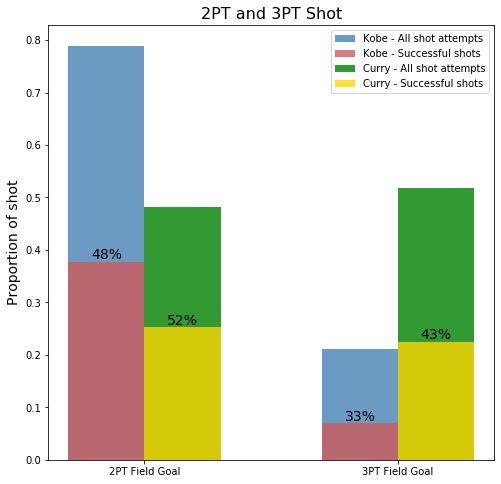

In [15]:
plotbyfigure2(data_kobe, data_curry, 'shot_type', '2PT and 3PT Shot',wid=0.3, size=(8,8))

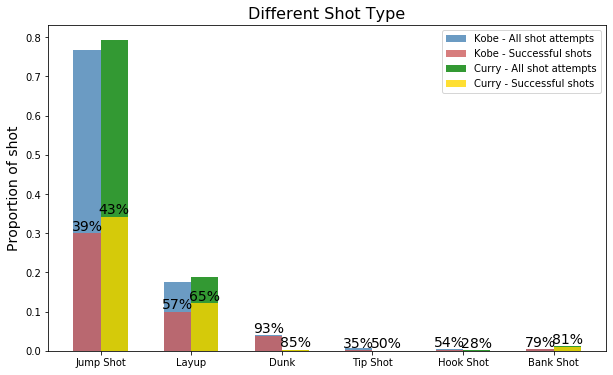

In [16]:
plotbyfigure2(data_kobe, data_curry, 'combined_shot_type', 'Different Shot Type',wid=0.3)

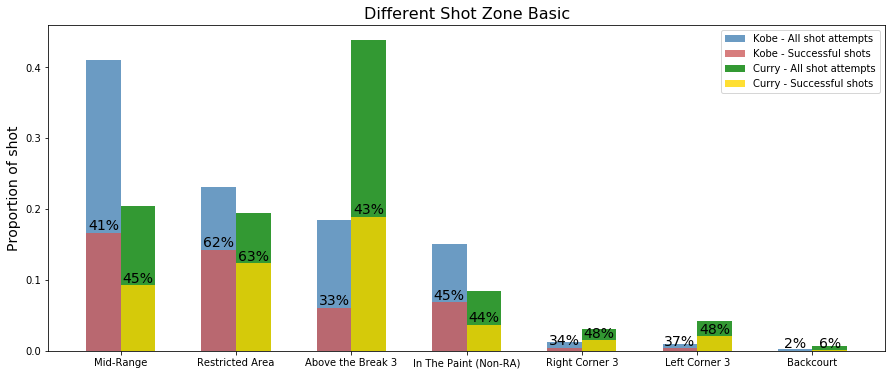

In [17]:
plotbyfigure2(data_kobe, data_curry, 'shot_zone_basic', 'Different Shot Zone Basic',wid=0.3,size=(15,6))

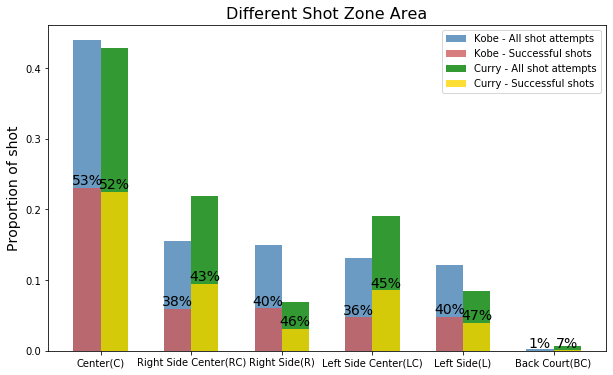

In [18]:
plotbyfigure2(data_kobe, data_curry, 'shot_zone_area', 'Different Shot Zone Area',wid=0.3,size=(10,6))

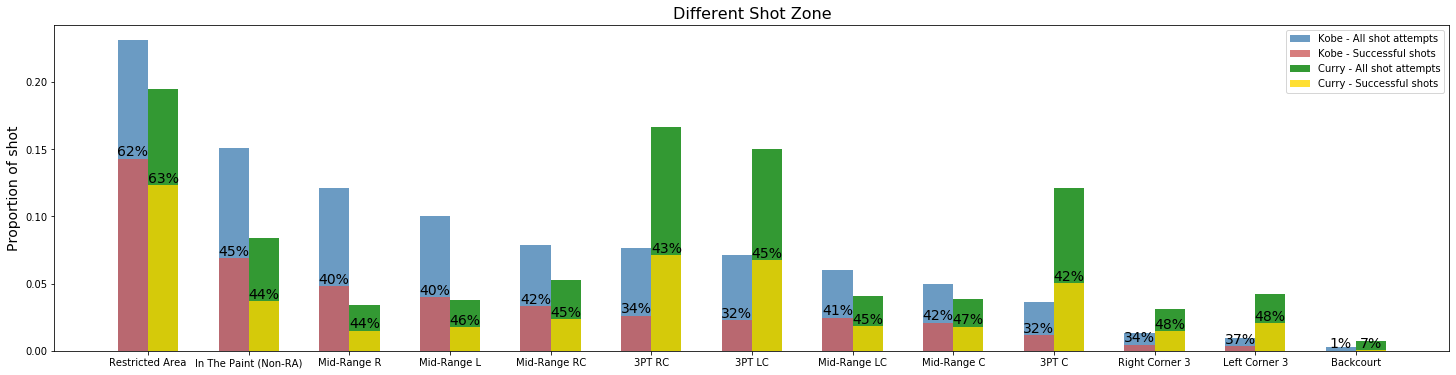

In [19]:
plotbyfigure2(data_kobe, data_curry, 'shot_zone', 'Different Shot Zone',wid=0.3,size=(25,6))

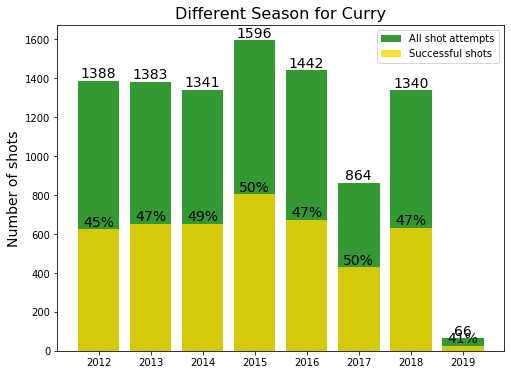

In [20]:
def plotbyfigure(data, figure, title, size=(8,6), shownum=None, wid=0.8):
    (xdata,ydata1,ydata2,hitrate)=gethitrate(data, figure)
    
    plt.figure(figsize=size)
    plt.bar(x=xdata, height=ydata1,width=wid, label='All shot attempts', color='green', alpha=0.8)
    plt.bar(x=xdata, height=ydata2,width=wid, label='Successful shots', color='gold', alpha=0.8)
    if shownum is None:    
        for i in range(0,len(xdata)):
            plt.text(xdata[i], ydata1[i], '%d'%ydata1[i], ha='center', size=14, va='bottom')
    else:
        for i in range(0,shownum):
            plt.text(xdata[i], ydata1[i], '%d'%ydata1[i], ha='center', size=14, va='bottom')
    for i in range(len(xdata)):
        plt.text(xdata[i], ydata2[i], '%.0f%%'%(hitrate[i]*100), ha='center', size=14, va='bottom')
    plt.legend()
    plt.ylabel('Number of shots',size=14)
    plt.title(title,size=16)
    plt.show()
plotbyfigure(data_curry, 'season', 'Different Season for Curry')